# GAN - Mixture of Gaussians Experiment

In [1]:
%load_ext autoreload
%autoreload 2
%matplotlib inline

In [2]:
# set up plotting
import seaborn as sns
import matplotlib as mpl
import matplotlib.pyplot as plt
sns.set_style('white')
sns.set(color_codes=True)

from IPython.display import clear_output

In [3]:
# add deep_networks to path
import sys
sys.path.append('..')

In [4]:
import numpy as np
import tensorflow as tf
assert tf.__version__ >= '1.4.0'

In [5]:
from deep_networks import data_util

In [6]:
def plot_gaussian(
    ax,
    data,
    codes=None,
    color='w',
    size=5,
    color_palette=sns.color_palette('Set1', n_colors=8,  desat=.5)):

    ax.set_aspect('equal')
    ax.set_ylim((-size, size))
    ax.set_xlim((-size, size))
    ax.tick_params(labelsize=10)
    if codes is not None:
        c = [color_palette[i] for i in codes]
        color = None
    else:
        c = None
    sns.kdeplot(data[:, 0], data[:, 1],
                 cmap='Blues', shade=True, shade_lowest=False, ax=ax)
    ax.scatter(data[:, 0], data[:, 1], linewidth=1, marker='+', c=c, color=color)

## Data Distribution

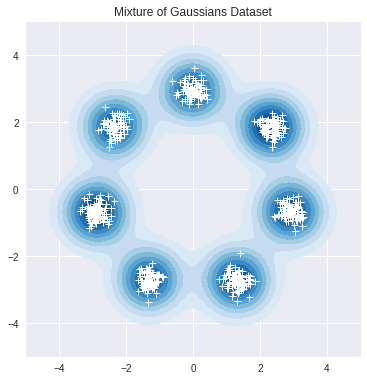

In [7]:
gm_num_examples = 5000
gm_num_classes = 7
gm_batch_size = 64
gm_num_batches = gm_num_examples // gm_batch_size
gm_output_shape = (2, )
gm_log_dir = 'logs/gm'

def get_gm_data():
    return data_util.gaussian_mixture(batch_size=gm_batch_size, scale=3.0, num_clusters=gm_num_classes)

gm_data, gm_labels = get_gm_data()

with tf.Session() as sess:
    fig, ax = plt.subplots(figsize=(6, 12))
    ax.set_title('Mixture of Gaussians Dataset')
    data = np.vstack([gm_data.eval() for _ in range(10)])
    plot_gaussian(ax, data)
    plt.show(fig)

In [8]:
gm_samples = {}

def sample_GAN(samples, num_batches, num_samples):
    def sample(gan, step):
        epoch = step // num_batches
        data = gan.sample(num_samples=num_samples)
        samples.append((epoch, data))

        clear_output()
        f, ax = plt.subplots(figsize=(6, 6))
        ax.set_title('Epoch #{}'.format(epoch))
        plot_gaussian(ax, data)
        plt.show(f)

    return sample

## Vanilla Generative Adversarial Networks

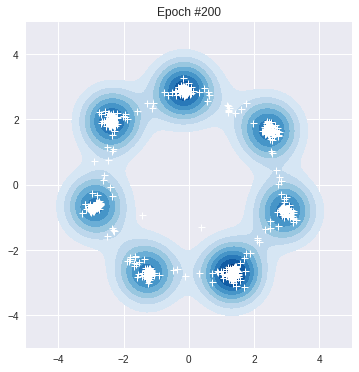

Epoch #200: 100%|██████████| 78/78 [00:01<00:00, 59.25it/s, d_loss=1.32, g_loss=1.04] 


In [9]:
from deep_networks.models.gan import GAN

with tf.Graph().as_default():
    with tf.Session() as sess:
        samples = []
        sample_step = [i * gm_num_batches for i in (10, 20, 50, 100, 200)]
        data, _ = get_gm_data()
        gan = GAN(sess,
                  data,
                  num_examples=gm_num_examples,
                  output_shape=gm_output_shape,
                  batch_size=gm_batch_size)
        gan.train(num_epochs=200,
                  log_dir=gm_log_dir,
                  sample_step=sample_step,
                  sample_fn=sample_GAN(samples, gm_num_batches, 700))
        gm_samples['GAN'] = samples

## Auxiliary Classifier Generative Adversarial Networks

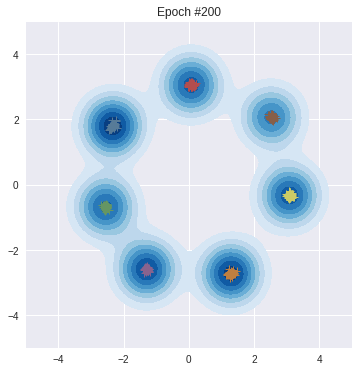

Epoch #200: 100%|██████████| 78/78 [00:01<00:00, 31.85it/s, d_c_accuracy=1, d_loss=2.23, g_c_accuracy=1, g_loss=1.22] 


In [10]:
from deep_networks.models.acgan import ACGAN

def sample_ACGAN(samples, num_batches, num_samples):
    def sample(gan, step):
        epoch = step // num_batches
        z = gan.sample_z(num_samples)
        c = gan.sample_c(num_samples)
        data = gan.sample(z=z, c=c)
        samples.append((epoch, data, c))

        clear_output()
        f, ax = plt.subplots(figsize=(6, 6))
        ax.set_title('Epoch #{}'.format(epoch))
        plot_gaussian(ax, data, codes=c)
        plt.show(f)

    return sample

with tf.Graph().as_default():
    with tf.Session() as sess:
        samples = []
        sample_step = [i * gm_num_batches for i in (10, 20, 50, 100, 200)]
        data, labels = get_gm_data()
        gan = ACGAN(sess,
                    data,
                    labels,
                    num_classes=gm_num_classes,
                    num_examples=gm_num_examples,
                    output_shape=gm_output_shape,
                    batch_size=gm_batch_size)
        gan.train(num_epochs=200,
                  log_dir=gm_log_dir,
                  sample_step=sample_step,
                  sample_fn=sample_ACGAN(samples, gm_num_batches, 700))
        gm_samples['ACGAN'] = samples

## Wasserstein GAN

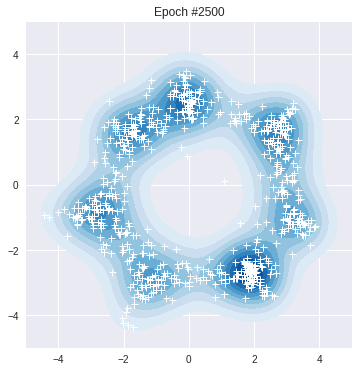

Epoch #2500: 100%|██████████| 78/78 [00:01<00:00, 63.34it/s, d_loss=6.38e-05, g_loss=-0.00389] 


In [11]:
from deep_networks.models.wgan import WGAN

with tf.Graph().as_default():
    with tf.Session() as sess:
        samples = []
        sample_step = [i * gm_num_batches for i in (100, 250, 500, 1500, 2500)]
        data, _ = get_gm_data()
        gan = WGAN(sess,
                   data,
                   num_examples=gm_num_examples,
                   output_shape=gm_output_shape,
                   batch_size=gm_batch_size)
        gan.train(num_epochs=2500,
                  log_dir=gm_log_dir,
                  sample_step=sample_step,
                  sample_fn=sample_GAN(samples, gm_num_batches, 700))
        gm_samples['WGAN'] = samples

## Improved Wasserstein GAN

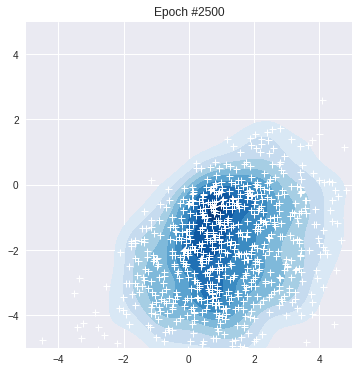


Epoch #2500: 100%|██████████| 78/78 [00:01<00:00, 67.40it/s, d_loss=0.464, g_loss=4.1]   


In [15]:
from deep_networks.models.iwgan import WGAN

with tf.Graph().as_default():
    with tf.Session() as sess:
        samples = []
        sample_step = [i * gm_num_batches for i in (100, 250, 500, 1500, 2500)]
        data, _ = get_gm_data()
        gan = WGAN(sess,
                   data,
                   num_examples=gm_num_examples,
                   output_shape=gm_output_shape,
                   batch_size=gm_batch_size,
                   reg_const=0.0)
        gan.train(num_epochs=2500,
                  log_dir=gm_log_dir,
                  sample_step=sample_step,
                  sample_fn=sample_GAN(samples, gm_num_batches, 700))
        gm_samples['iWGAN'] = samples

## GAN Results Comparison

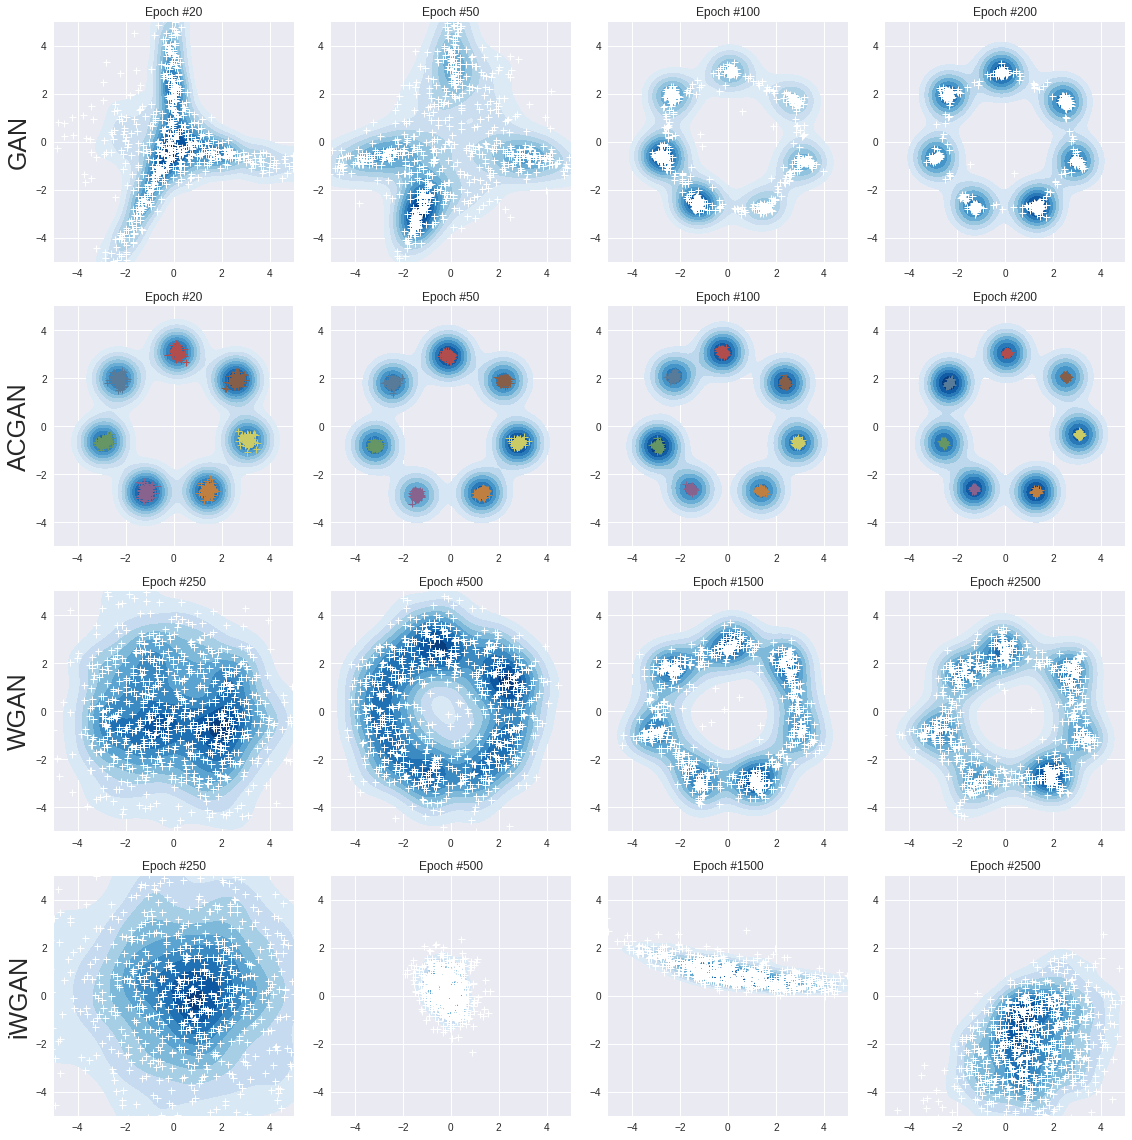

In [16]:
headers = ['GAN', 'ACGAN', 'WGAN', 'iWGAN']
num_rows = len(headers)
num_cols = 4

fig, axes = plt.subplots(num_rows, num_cols, figsize=(num_cols * 4, 4 * num_rows))

for r, h in enumerate(headers):
    samples = gm_samples[h][1:]
    axes[r][0].set_ylabel(h, rotation=90, size=25)
    for col, ax in enumerate(axes[r]):
        ax.set_title('Epoch #{}'.format(samples[col][0]))
        if len(samples[col]) == 2:
            codes = None
        else:
            codes = samples[col][2]
        plot_gaussian(ax, samples[col][1], codes=codes)

fig.tight_layout()
plt.show(fig)

## Discover Cross-Domain Relations with Generative Adversarial Networks

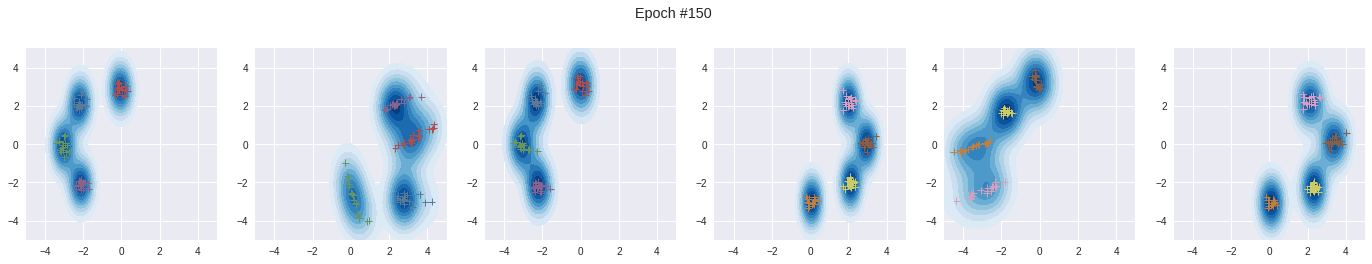


Epoch #150: 100%|██████████| 78/78 [00:04<00:00, 16.78it/s, d_loss=0.509, g_loss=-3.83]

In [17]:
from deep_networks.models.discogan import DiscoGAN

gm_num_classes_even = 8

def sample_DiscoGAN(sess, samples, num_batches, num_samples):
    def sample(gan, step):
        epoch = step // num_batches
        sample_labels_x = []
        sample_data_x = []
        sample_gen_y = []
        sample_recon_x = []

        sample_labels_y = []
        sample_data_y = []
        sample_gen_x = []
        sample_recon_y = []
        for i in range(4):
            data_x, labels_x = sess.run(data_util.gaussian_mixture(batch_size=num_samples // gm_num_classes_even,
                                                                   scale=3.0,
                                                                   num_clusters=8,
                                                                   minval=i,
                                                                   maxval=i+1))
            data_x, gen_y, recon_x = gan.sample_y(x=data_x)

            sample_labels_x.append(labels_x)
            sample_data_x.append(data_x)
            sample_gen_y.append(gen_y)
            sample_recon_x.append(recon_x)


            data_y, labels_y = sess.run(data_util.gaussian_mixture(batch_size=num_samples // gm_num_classes_even,
                                                                   scale=3.0,
                                                                   num_clusters=8,
                                                                   minval=i+4,
                                                                   maxval=i+5))
            data_y, gen_x, recon_y = gan.sample_x(y=data_y)

            sample_labels_y.append(labels_y)
            sample_data_y.append(data_y)
            sample_gen_x.append(gen_x)
            sample_recon_y.append(recon_y)

        cols = [
            np.concatenate(sample_labels_x),
            np.vstack(sample_data_x),
            np.vstack(sample_gen_y),
            np.vstack(sample_recon_x),
            np.concatenate(sample_labels_y),
            np.vstack(sample_data_y),
            np.vstack(sample_gen_x),
            np.vstack(sample_recon_y),
        ]
        samples.append((epoch, cols))

        num_rows = 1
        num_cols = 6

        clear_output()

        fig, axes = plt.subplots(num_rows, num_cols, figsize=(num_cols * 4, 4 * num_rows))
        fig.suptitle('Epoch #{}'.format(epoch))
        for i in range(3):
            plot_gaussian(axes[i], cols[i+1], codes=cols[0])
            plot_gaussian(axes[i+3], cols[i+5], codes=cols[4])
        plt.show(fig)

    return sample

with tf.Graph().as_default():
    with tf.Session() as sess:
        samples = []
        sample_step = [i * gm_num_batches for i in (20, 50, 100, 150)]
        data_x, _ = data_util.gaussian_mixture(batch_size=gm_batch_size,
                                               scale=3.0,
                                               num_clusters=gm_num_classes_even,
                                               maxval=4)
        data_y, _ = data_util.gaussian_mixture(batch_size=gm_batch_size,
                                               scale=3.0,
                                               num_clusters=gm_num_classes_even,
                                               minval=4)
        gan = DiscoGAN(sess,
                       data_x,
                       data_y,
                       num_examples=gm_num_examples,
                       x_output_shape=gm_output_shape,
                       y_output_shape=gm_output_shape,
                       batch_size=gm_batch_size)

        gan.train(num_epochs=150,
                  log_dir=gm_log_dir,
                  sample_step=sample_step,
                  sample_fn=sample_DiscoGAN(sess, samples, gm_num_batches, 150))

        gm_samples['DiscoGAN'] = samples

## DiscoGAN Results

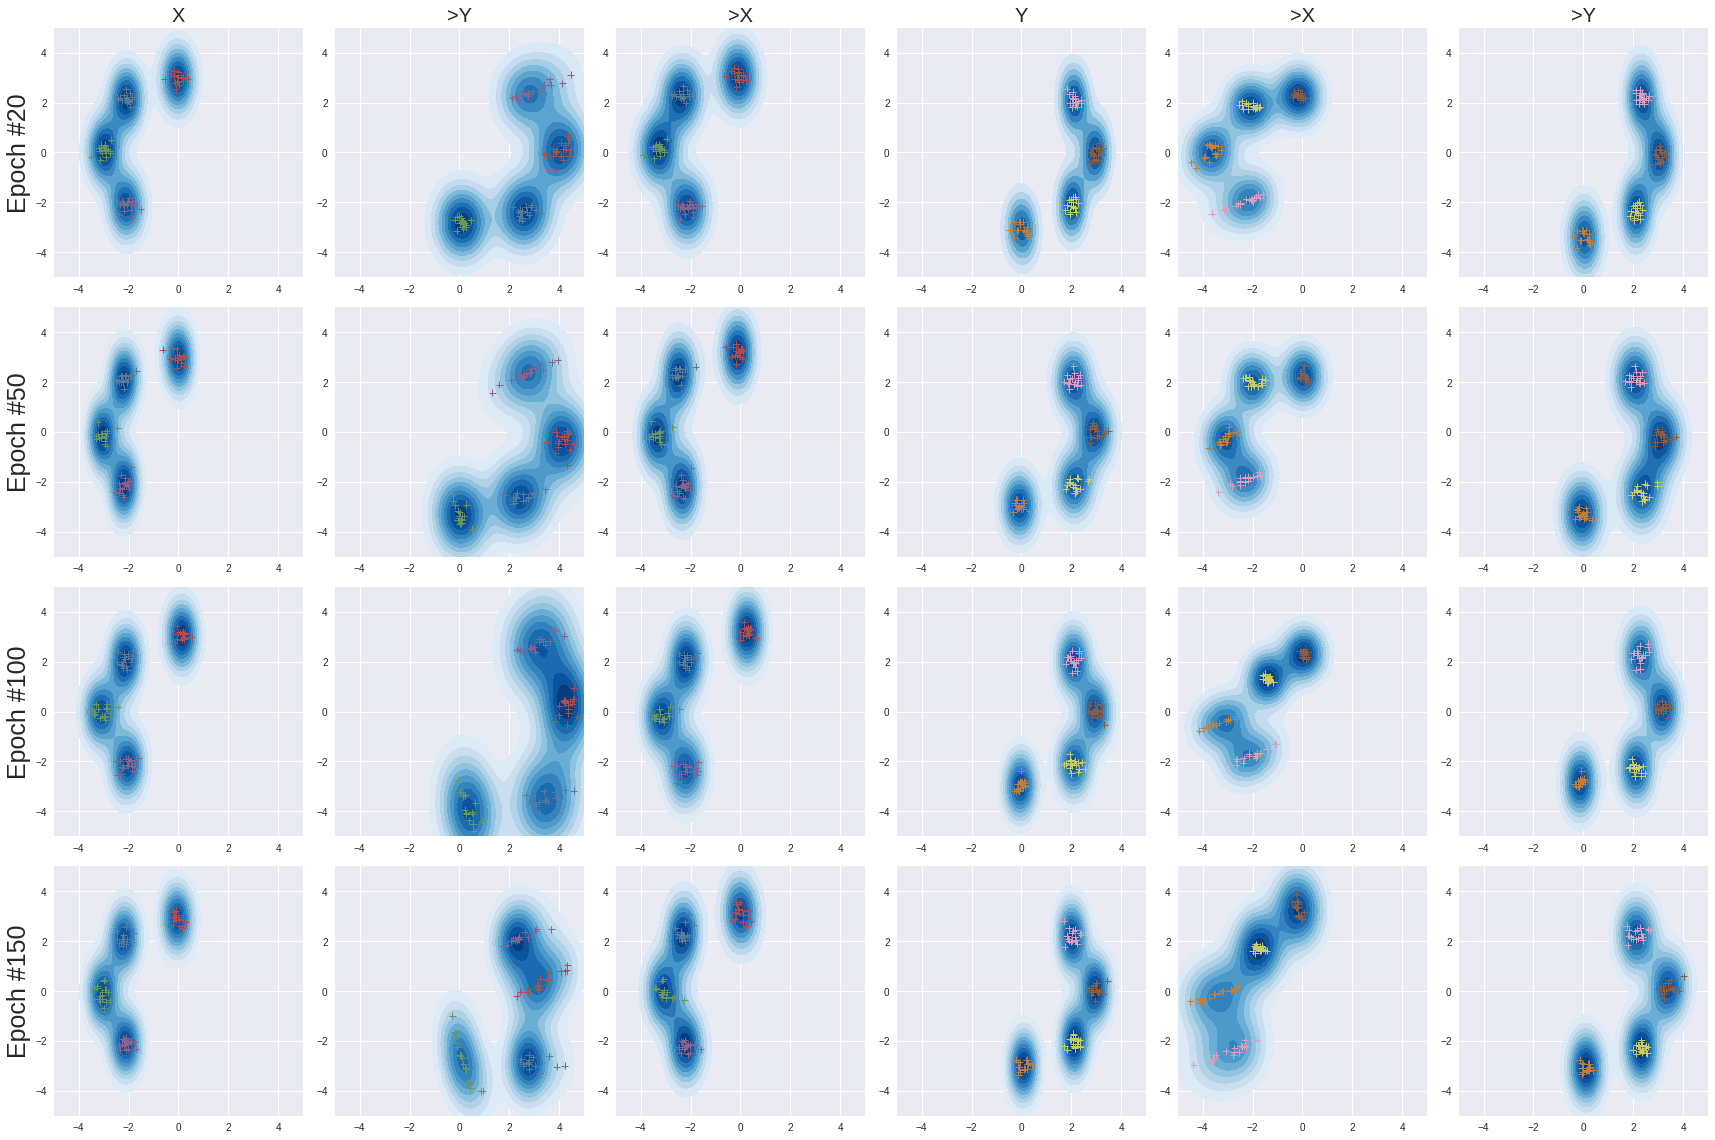

In [18]:
rows = [('Epoch #{}'.format(step), data) for step, data in gm_samples['DiscoGAN']]
num_rows = len(rows)
num_cols = 6

fig, axes = plt.subplots(num_rows, num_cols, figsize=(num_cols * 4, 4 * num_rows))

titles = ['X', '>Y', '>X', 'Y', '>X', '>Y']
for title, ax in zip(titles, axes[0]):
    ax.set_title(title, fontsize=20)

for r, (h, samples) in enumerate(rows):
    axes[r][0].set_ylabel(h, rotation=90, size=25)
    for i in range(3):
        plot_gaussian(axes[r][i], samples[i+1], codes=samples[0])
        plot_gaussian(axes[r][i+3], samples[i+5], codes=samples[4])

fig.tight_layout()
plt.show(fig)